# Imports

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import time
import math

# Parameters

In [2]:
# Dataset
batch_size = 128
val_batch_size = 4

# Model
num_classes = 10
in_channels= 3

start_channels = 64
sequence_length = 4
blocks_per_stage = 2

num_convs= 2
out_channels_sequence = [start_channels * 2 ** i for i in range(sequence_length)]
num_blocks = [blocks_per_stage] * len(out_channels_sequence)

# Training
num_epochs = 150
# Optimisers
lr=0.2
momentum=0.9
weight_decay=5e-4

# Initialise lists to store metrics
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Use GPU
device = torch.device("cuda:0")

# Cutout transformation

In [3]:
# Custom cutout augmentation
class Cutout(object):
    """
    Randomly masks out one or more patches from an image.
    """

    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0.0

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask

        return img

# 1. Read dataset and create dataloaders: 5%

In [4]:
# Dataset augmentation transformation
transform_augmented = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        Cutout(n_holes=1, length=16),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Validation and testing dataset transformation
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Create dataloaders
    # Training data
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_augmented
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)
    # Testing data
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
valloader = torch.utils.data.DataLoader(
    testset, batch_size=val_batch_size, shuffle=False, num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


# 2. Create the model: 40%

In [10]:
class Block(nn.Module):
    """
    A block within the Backbone.

    Consists of:
        SpatialAveragePool.
        Linear layer.
        K Conv layers.
    """

    def __init__(self, in_channels, out_channels, num_convs):
        super(Block, self).__init__()
        kernel_size=3
        # SpatialAveragePool to vector of d channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # Linear layer transforming pooled output to a vector with K elements
        self.fc = nn.Linear(in_channels, num_convs)
        # K Conv layers
        self.convs = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels, out_channels, kernel_size, padding=kernel_size // 2
                    ),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                )
                for _ in range(num_convs)
            ]
        )

    def forward(self, x):
        # Calculating weight vector a = [a1, ..., ak] with g
        weight_vector = F.softmax(self.fc(self.avg_pool(x).squeeze()), dim=-1)
        conv_outputs = torch.stack([conv(x) for conv in self.convs], dim=2)
        # Combining Conv layer outputs with calculated weights a to produce a single output O.
        weighted_output = torch.sum(
            conv_outputs * weight_vector.unsqueeze(1).unsqueeze(-1).unsqueeze(-1), dim=2
        )
        return weighted_output


class Backbone(nn.Module):
    """
    Consists of N Blocks, each with a certain number of convolutional layers.
    """

    def __init__(
        self, num_blocks, num_convs, in_channels, out_channels_sequence):
        super(Backbone, self).__init__()
        self.features = nn.Sequential()

        # Constructing Blocks and Pooling layers
        for i, num_block in enumerate(num_blocks):
            for j in range(num_block):
                self.features.add_module(
                    f"block_{i}_{j}",
                    Block(in_channels, out_channels_sequence[i], num_convs),
                )
                in_channels = out_channels_sequence[i]
            self.features.add_module(f"pool_{i}_{j}", nn.MaxPool2d(kernel_size=2, stride=2))

    def forward(self, x):
        return self.features(x)


class Classifier(nn.Module):
    """
    Calculates the mean feature vector ƒ by applying SpatialAveragePool to the Backbone's output. Then passes ƒ through a MLP classifier.
    """

    def __init__(self, in_features, num_classes):
        super(Classifier, self).__init__()
        # Computes a mean feature vector ƒ by applying SpatialAveragePool to the Backbone's output.
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        hidden_features = in_features * 2

        # MLP classifier
        self.mlp = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_features, num_classes)
        )

    def forward(self, x):
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        return x


class Model(nn.Module):
    """
    Architecture based on Convolutional Neural Networks that uses a Backbone and a Classifier.
    """

    def __init__(self, num_classes, num_blocks, num_convs, in_channels, out_channels_sequence):
        super(Model, self).__init__()
        
        # Backbone
        self.backbone = Backbone(
            num_blocks,
            num_convs,
            in_channels,
            out_channels_sequence,
        )

        # Classifier
        final_in_channels = out_channels_sequence[-1]
        self.classifier = Classifier(final_in_channels, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        # Process the output of the last Block in the Backbone through Classifier
        x = self.classifier(x)
        return x


# Initialize model
net = Model(num_classes, num_blocks, num_convs, in_channels, out_channels_sequence).to(device)

[64, 128, 256, 512] [2, 2, 2, 2]


# 3. Create the loss and optimizer: 5%

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

# 4. Write the training script to train the model. 30%

In [7]:
# Calculate accuracy helper
def calculate_accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float().sum()
    accuracy = correct / y_true.shape[0]
    return accuracy

# Evaluate the model on the test set
def evaluate_model(model, loader, criterion, device):
    model.eval()
    test_loss, test_accuracy = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_accuracy += calculate_accuracy(outputs, labels).item()

    avg_loss = test_loss / len(loader)
    avg_accuracy = test_accuracy / len(loader)
    return avg_loss, avg_accuracy

# Calculate training loss and accuracy
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_accuracy = 0.0, 0.0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += calculate_accuracy(outputs, labels).item()

    avg_loss = running_loss / len(loader)
    avg_accuracy = running_accuracy / len(loader)
    return avg_loss, avg_accuracy

tic = time.process_time()

# Training and testing loop
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(
        net, trainloader, optimizer, criterion, device
    )
    lr_scheduler.step()

    test_loss, test_accuracy = evaluate_model(net, valloader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print live metrics
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], "
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
        f"Time: {(time.process_time()-tic):.1f}s"
    )

Epoch [1/150], Train Loss: 2.1009, Train Accuracy: 0.1864, Test Loss: 2.0316, Test Accuracy: 0.2125, Time: 19.2s
Epoch [2/150], Train Loss: 1.7993, Train Accuracy: 0.3013, Test Loss: 1.5674, Test Accuracy: 0.4134, Time: 38.0s
Epoch [3/150], Train Loss: 1.5164, Train Accuracy: 0.4443, Test Loss: 1.3234, Test Accuracy: 0.5433, Time: 56.7s
Epoch [4/150], Train Loss: 1.3054, Train Accuracy: 0.5376, Test Loss: 1.5822, Test Accuracy: 0.5004, Time: 75.4s
Epoch [5/150], Train Loss: 1.1945, Train Accuracy: 0.5837, Test Loss: 1.1379, Test Accuracy: 0.6007, Time: 94.4s
Epoch [6/150], Train Loss: 1.0996, Train Accuracy: 0.6237, Test Loss: 1.0858, Test Accuracy: 0.6355, Time: 113.5s
Epoch [7/150], Train Loss: 1.0219, Train Accuracy: 0.6526, Test Loss: 1.4103, Test Accuracy: 0.5921, Time: 132.2s
Epoch [8/150], Train Loss: 0.9812, Train Accuracy: 0.6694, Test Loss: 1.1587, Test Accuracy: 0.6208, Time: 151.2s
Epoch [9/150], Train Loss: 0.9623, Train Accuracy: 0.6722, Test Loss: 1.0226, Test Accuracy: 

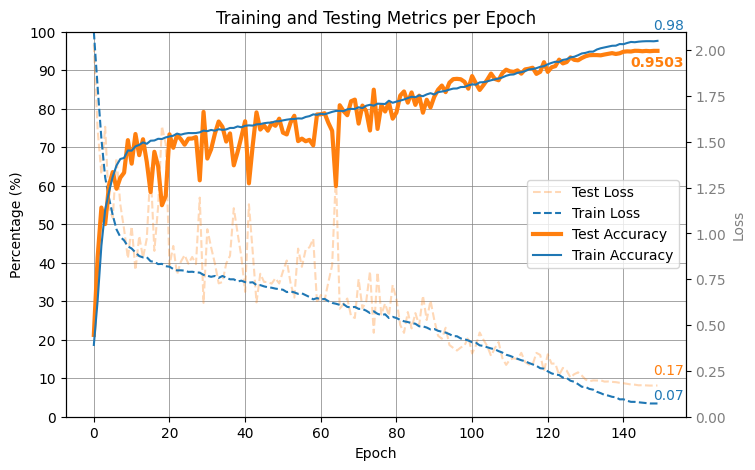

In [77]:
max_loss_value = train_losses[0]
train_losses_percent = [loss / max_loss_value * 100 for loss in train_losses]
test_losses_percent = [loss / max_loss_value * 100 for loss in test_losses]

train_accuracies_percent = [acc * 100 for acc in train_accuracies]
test_accuracies_percent = [acc * 100 for acc in test_accuracies]

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(test_losses_percent, label='Test Loss', color='tab:orange', linestyle='dashed', alpha=0.3)
ax.plot(train_losses_percent, label='Train Loss', color='tab:blue', linestyle='dashed')
ax.plot(test_accuracies_percent, label='Test Accuracy', color='tab:orange', linewidth=3)
ax.plot(train_accuracies_percent, label='Train Accuracy', color='tab:blue')

ax.set_xlabel('Epoch')

ax.set_ylabel('Percentage (%)')
ax.grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_ylim(0, 100)

ax2 = ax.twinx()
ax2.set_ylabel('Loss', color='tab:grey')
ax2.tick_params(axis='y', labelcolor='tab:grey') 
ax2.set_ylim(0, train_losses[0])  # Match the visual range of the primary axis

offset = max(max(train_losses), max(test_losses), max(train_accuracies), max(test_accuracies)) * 0.04
adjustment = 7

ax.text(num_epochs - 1 + adjustment, train_losses_percent[-1] + 1 + offset, f"{train_losses[-1]:.2f}", color='tab:blue', ha='right')
ax.text(num_epochs - 1 + adjustment, test_losses_percent[-1] + 3 - offset, f"{test_losses[-1]:.2f}", color='tab:orange', ha='right')
ax.text(num_epochs - 1 + adjustment, train_accuracies_percent[-1] + 3 + offset, f"{train_accuracies[-1]:.2f}", color='tab:blue', ha='right')
ax.text(num_epochs - 1 + adjustment, test_accuracies_percent[-1] - 4 + offset, f"{test_accuracies[-1]:.4f}", color='tab:orange', ha='right', weight='bold')

plt.title('Training and Testing Metrics per Epoch')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.savefig('metrics.png')
plt.show()


# 5. Final model accuracy on CIFAR-10 Validation Set: 20%
You should achieve 94% with this model.

In [9]:
# CODE TAKEN FROM https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=15
)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final model accuracy: {100 * correct / total:.4f} %")

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Final model accuracy: 95.0300 %
